In [1]:
#Importing packages
import praw
import requests
import pandas as pd
import json
from datetime import datetime, timedelta, date

#Configs for API keys
from config import reddit_client_id
from config import reddit_secret_key
from config import reddit_user_name
from config import reddit_password
from config import yahoo_api_key

#Graphs, math, and stats
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import linregress
from scipy import stats

In [2]:
#Base URL for rapidapi yahoo finance
yahoo_base_url = "https://yahoo-finance127.p.rapidapi.com/price/"

#API key and host
headers_yahoo = {
    "X-RapidAPI-Key": yahoo_api_key,
    "X-RapidAPI-Host": "yahoo-finance127.p.rapidapi.com"
}

#get input from user for stock symbol / empty list 
company_names = []
stock_symbol = str(input("Enter stock symbol to search"))

#------------------------------------------------------------------------TO-DO - Add error handling for when ticker is not found
#Grabbing URL, stock symbol, converting to JSON
yahoo_response = requests.get(yahoo_base_url + stock_symbol, headers=headers_yahoo).json()
#yahoo_response

#Add longname as search term for reddit
company_names.append(yahoo_response["longName"])

#Add stock symbol as search term for reddit
company_names.append(stock_symbol)

#Get alternate company names to use for reddit search
msg = f"{stock_symbol}'s LongName is {company_names[0]}.  Add another search term and press Enter, or press Cancel when done'"

#While loop to add company name
while True:
    response = str(input(msg))
    if len(response)> 0:
        company_names.append(response)
    else:
        break

#remove duplicates from company_names
reddit_search_list = pd.Series(company_names).drop_duplicates().tolist()

In [3]:
#Checking reponse from rapid API
print(yahoo_response)

{'symbol': 'TSLA', 'twoHundredDayAverageChangePercent': {'raw': 0.113268755, 'fmt': '11.33%'}, 'averageAnalystRating': '2.8 - Hold', 'fiftyTwoWeekLowChangePercent': {'raw': 1.4658679, 'fmt': '146.59%'}, 'language': 'en-US', 'earningsTimestampEnd': {'raw': 1706529600, 'fmt': '2024-01-29', 'longFmt': '2024-01-29T07:00'}, 'regularMarketDayRange': {'raw': '240.79 - 253.88', 'fmt': '240.79 - 253.88'}, 'epsForward': {'raw': 3.55, 'fmt': '3.55'}, 'regularMarketDayHigh': {'raw': 253.88, 'fmt': '253.88'}, 'twoHundredDayAverageChange': {'raw': 25.542908, 'fmt': '25.54'}, 'twoHundredDayAverage': {'raw': 225.5071, 'fmt': '225.51'}, 'askSize': {'raw': 18, 'fmt': '18', 'longFmt': '18'}, 'bookValue': {'raw': 16.818, 'fmt': '16.82'}, 'fiftyTwoWeekHighChange': {'raw': -48.240005, 'fmt': '-48.24'}, 'marketCap': {'raw': 798067851264, 'fmt': '798.068B', 'longFmt': '798,067,851,264'}, 'fiftyTwoWeekRange': {'raw': '101.81 - 299.29', 'fmt': '101.81 - 299.29'}, 'fiftyDayAverageChange': {'raw': 17.319809, 'fmt

In [4]:
#Grabbing function method to access reddit
auth = requests.auth.HTTPBasicAuth(reddit_client_id,reddit_secret_key)
data = {
    'grant_type': 'password',
    'username': reddit_user_name,
    'password': reddit_password
}
headers = {'User-Agent': 'redditapi/1'}
#Grabbing posts from reddit
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)
token12 = res.json()['access_token']
headers = {**headers, **{'Authorization': f'bearer {token12}'}}
headers
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)
#Creating empty list to store reddit posts
reddit_posts = []

#Activating Praw
reddit = praw.Reddit(
    client_id=reddit_client_id,
    client_secret=reddit_secret_key,
    password = data['password'],
    user_agent=f"testscript by u/{data['username']}",
    username = data['username'],
)


#-----------------------------------------------------------TO-DO: Do we need to set a different limit or search criteria?
#Using praw to get subreddit easily
for term in reddit_search_list:
    for submission in reddit.subreddit("wallstreetbets").search(term, limit=50, sort="new"):
        sub_create_utc = datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d') 
        reddit_posts.append({"search term": term,
                             "title": submission.title,
                            "upvotes": submission.score,
                            "num_comments": submission.num_comments,
                            "date_utc": sub_create_utc})
#Creating Dataframe
reddit_df = pd.DataFrame(reddit_posts)
reddit_df.drop_duplicates(subset=["title"],keep="first",inplace=True)
reddit_df

,search term,title,upvotes,num_comments,date_utc
0,"Tesla, Inc.","RIVN GAIN, DIAMOND HANDS",30,22,2023-12-14
1,"Tesla, Inc.",JPOW looking at job data today,10,1,2023-12-08
2,"Tesla, Inc.",Where is all the damn gain porn?,32,39,2023-12-07
3,"Tesla, Inc.",TSLA Institutional Ownership Over Time.,12,5,2023-11-28
4,"Tesla, Inc.",Tesla insiders had perfect timing with selling...,97,27,2023-11-20
...,...,...,...,...,...
93,tsla,Closed the TSLA puts but the rest is total los...,245,65,2023-11-03
95,tsla,Price vs monthly payments of TSLA Long Range M...,12,14,2023-11-03
96,tsla,Shorting this week’s rally. Today I bought PLT...,161,127,2023-11-02
98,tsla,"You guys were right, I was less right",106,35,2023-10-30


In [5]:
#Prepping Yahoo Rapid API for JSON print
url = f"https://yahoo-finance127.p.rapidapi.com/historic/{stock_symbol}/1d/1000d"
#Printing yahoo Rapid API 
yahoo_response2 = requests.get(url,headers=headers_yahoo).json()
yahoo_response2

{'meta': {'currency': 'USD',
  'symbol': 'TSLA',
  'exchangeName': 'NMS',
  'instrumentType': 'EQUITY',
  'firstTradeDate': 1277818200,
  'regularMarketTime': 1702587601,
  'gmtoffset': -18000,
  'timezone': 'EST',
  'exchangeTimezoneName': 'America/New_York',
  'regularMarketPrice': 251.05,
  'chartPreviousClose': 28.35,
  'priceHint': 2,
  'currentTradingPeriod': {'pre': {'timezone': 'EST',
    'start': 1702544400,
    'end': 1702564200,
    'gmtoffset': -18000},
   'regular': {'timezone': 'EST',
    'start': 1702564200,
    'end': 1702587600,
    'gmtoffset': -18000},
   'post': {'timezone': 'EST',
    'start': 1702587600,
    'end': 1702602000,
    'gmtoffset': -18000}},
  'dataGranularity': '1d',
  'range': '1000d',
  'validRanges': ['1d',
   '5d',
   '1mo',
   '3mo',
   '6mo',
   '1y',
   '2y',
   '5y',
   '10y',
   'ytd',
   'max']},
 'timestamp': [1577370600,
  1577457000,
  1577716200,
  1577802600,
  1577975400,
  1578061800,
  1578321000,
  1578407400,
  1578493800,
  157858

In [6]:
#Empty list to store yahoo finance data
yahoo_finance3 = []
#Creating loop to create add data to list
x = 0
for date_data in yahoo_response2['timestamp']:
    formatted_date = datetime.utcfromtimestamp(yahoo_response2['timestamp'][x]).strftime('%Y-%m-%d') 
    
    yahoo_finance3.append({"Symbol": yahoo_response2['meta']["symbol"],
                        "date_utc": formatted_date,
                        "Open": yahoo_response2['indicators']['quote'][0]['open'][x],
                        "Volume": yahoo_response2['indicators']['quote'][0]['volume'][x],
                        "High": yahoo_response2['indicators']['quote'][0]['high'][x],
                        "Close": yahoo_response2['indicators']['quote'][0]['close'][x],
                        "Low": yahoo_response2['indicators']['quote'][0]['low'][x]})
    
    x += 1

#Creating dataframe from list
yahoo_finance3_df = pd.DataFrame(yahoo_finance3)

#Finding Daily Change price from "close" and "open" price
yahoo_finance3_df["Daily Change"] = yahoo_finance3_df["Close"] - yahoo_finance3_df["Open"]
print(yahoo_finance3_df)


    Symbol    date_utc        Open     Volume        High       Close  \
0     TSLA  2019-12-26   28.527332  159508500   28.898666   28.729334   
1     TSLA  2019-12-27   29.000000  149185500   29.020666   28.691999   
2     TSLA  2019-12-30   28.586000  188796000   28.600000   27.646667   
3     TSLA  2019-12-31   27.000000  154285500   28.086000   27.888666   
4     TSLA  2020-01-02   28.299999  142981500   28.713333   28.684000   
..     ...         ...         ...        ...         ...         ...   
995   TSLA  2023-12-08  240.270004  102980100  245.270004  243.839996   
996   TSLA  2023-12-11  242.740005   97913900  243.440002  239.740005   
997   TSLA  2023-12-12  238.550003   95328300  238.990005  237.009995   
998   TSLA  2023-12-13  234.190002  146286300  240.300003  239.289993   
999   TSLA  2023-12-14  241.220001  160015841  253.880005  251.050003   

            Low  Daily Change  
0     28.423332      0.202002  
1     28.407333     -0.308001  
2     27.284000     -0.9393

In [7]:
#Merging the reddit data and yahoo finance data
merged_df = pd.merge(reddit_df,yahoo_finance3_df)
merged_df = merged_df.sort_values(by='date_utc')
merged_df

,search term,title,upvotes,num_comments,date_utc,Symbol,Open,Volume,High,Close,Low,Daily Change
54,"Tesla, Inc.",2022 u/GlideOutside “margin: never again.” 202...,296,152,2023-06-08,TSLA,224.220001,164489700,235.229996,234.860001,223.009995,10.639999
53,"Tesla, Inc.",$TSLA chart,35,24,2023-06-15,TSLA,248.399994,160171200,258.950012,255.899994,247.289993,7.500000
52,"Tesla, Inc.",$FSR Shorts Don't Stand a Chance,28,59,2023-06-26,TSLA,250.070007,179990600,258.369995,241.050003,240.699997,-9.020004
51,"Tesla, Inc.",Time to secure profits and sell everything or ...,106,120,2023-06-28,TSLA,249.699997,159770800,259.880005,256.239990,248.889999,6.539993
50,"Tesla, Inc.",Tesla float getting close to 0,0,38,2023-06-30,TSLA,260.600006,112267600,264.450012,261.769989,259.890015,1.169983
...,...,...,...,...,...,...,...,...,...,...,...,...
56,tsla,Where's Our TSLA Bulls At Today?,1296,192,2023-12-13,TSLA,234.190002,146286300,240.300003,239.289993,228.199997,5.099991
55,tsla,-32k; 22 years old,34,23,2023-12-13,TSLA,234.190002,146286300,240.300003,239.289993,228.199997,5.099991
1,tsla,Quoting After a Win,4,2,2023-12-14,TSLA,241.220001,160015841,253.880005,251.050003,240.789993,9.830002
2,tsla,"Today was great, but…",2,84,2023-12-14,TSLA,241.220001,160015841,253.880005,251.050003,240.789993,9.830002


In [8]:
#Removing huge outliers from reddit upvotes and comments
merged_df = merged_df[(np.abs(stats.zscore(merged_df['upvotes'])) < 3)]
merged_df = merged_df[(np.abs(stats.zscore(merged_df['num_comments'])) < 3)]
merged_df

,search term,title,upvotes,num_comments,date_utc,Symbol,Open,Volume,High,Close,Low,Daily Change
54,"Tesla, Inc.",2022 u/GlideOutside “margin: never again.” 202...,296,152,2023-06-08,TSLA,224.220001,164489700,235.229996,234.860001,223.009995,10.639999
53,"Tesla, Inc.",$TSLA chart,35,24,2023-06-15,TSLA,248.399994,160171200,258.950012,255.899994,247.289993,7.500000
52,"Tesla, Inc.",$FSR Shorts Don't Stand a Chance,28,59,2023-06-26,TSLA,250.070007,179990600,258.369995,241.050003,240.699997,-9.020004
51,"Tesla, Inc.",Time to secure profits and sell everything or ...,106,120,2023-06-28,TSLA,249.699997,159770800,259.880005,256.239990,248.889999,6.539993
50,"Tesla, Inc.",Tesla float getting close to 0,0,38,2023-06-30,TSLA,260.600006,112267600,264.450012,261.769989,259.890015,1.169983
...,...,...,...,...,...,...,...,...,...,...,...,...
56,tsla,Where's Our TSLA Bulls At Today?,1296,192,2023-12-13,TSLA,234.190002,146286300,240.300003,239.289993,228.199997,5.099991
55,tsla,-32k; 22 years old,34,23,2023-12-13,TSLA,234.190002,146286300,240.300003,239.289993,228.199997,5.099991
1,tsla,Quoting After a Win,4,2,2023-12-14,TSLA,241.220001,160015841,253.880005,251.050003,240.789993,9.830002
2,tsla,"Today was great, but…",2,84,2023-12-14,TSLA,241.220001,160015841,253.880005,251.050003,240.789993,9.830002


In [9]:
# # Linear regression on Reddit upvotes and comments, yahoo prices
# x_values = merged_df['Daily Change']
# y_values = merged_df['upvotes']

# # Perform a linear regression on X and Y
# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

# # Get regression values
# regress_values = x_values * slope + intercept
# print(regress_values)
# print(slope)
# #Creating line equation
# line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
# print(line_eq)
# # Create Plot
# plt.scatter(x_values,y_values)
# plt.plot(x_values,regress_values,"r-")

# # Label plot and annotate the line equation
# plt.xlabel('Open')
# plt.ylabel('Comments')
# plt.annotate(line_eq,(20,5),fontsize=15,color="red")

# # Print r value
# print(f"The r-value is: {rvalue**2}")

# # Show plot
# plt.show()

In [10]:

# yahoo_finance = []

# yahoo_finance.append({"Symbol": yahoo_response["symbol"],
#                         "Day_Range_raw": yahoo_response["regularMarketDayRange"]["raw"],
#                         "Market_Price": yahoo_response["regularMarketPrice"]["raw"],
#                         "Company_Name": yahoo_response["longName"]})

# yahoo_finance_df = pd.DataFrame(yahoo_finance)
# yahoo_finance_df.head()


In [11]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# import pandas as pd

# # Sample DataFrame with a column of sentences
# # Assuming merged_df is already defined

# sentences_list = []

# for index, row in merged_df.iterrows():
#     sentences_list.append(row['title'])

# # Creating a DataFrame from the list of sentences
# df = pd.DataFrame({"sentences": sentences_list})

# # Combining all sentences into a single string
# text = " ".join(sentence for sentence in df["sentences"])

# # Generating the word cloud
# wordcloud = WordCloud(width=800, height=800,
#                       background_color='white',
#                       min_font_size=10).generate(text)

# # Displaying the WordCloud
# plt.figure(figsize=(8, 8), facecolor=None)
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.tight_layout(pad=0)
# plt.show()

In [12]:
# import matplotlib.pyplot as plt
# # Plot the charts and apply some styling
# danger_drop, = plt.plot(merged_df['Daily Change'], merged_df['upvotes'], color="red", label="Danger Drop")
# railgun, = plt.plot(merged_df['Daily Change'], merged_df['num_comments'], color="blue", label="RailGun")

In [13]:
#merged_df['date_utc'] =pd.to_datetime(merged_df['date_utc'])
#merged_df['scaled_price'] = merged_df['Open']*20
#merged_df.set_index('date_utc', inplace=True)
#merged_df[['upvotes', 'num_comments']].plot(kind='bar', figsize=(10, 6))
#merged_df['scaled_price'].plot(kind='line', secondary_y=True)

#plt.title('Trends over Time')
#plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

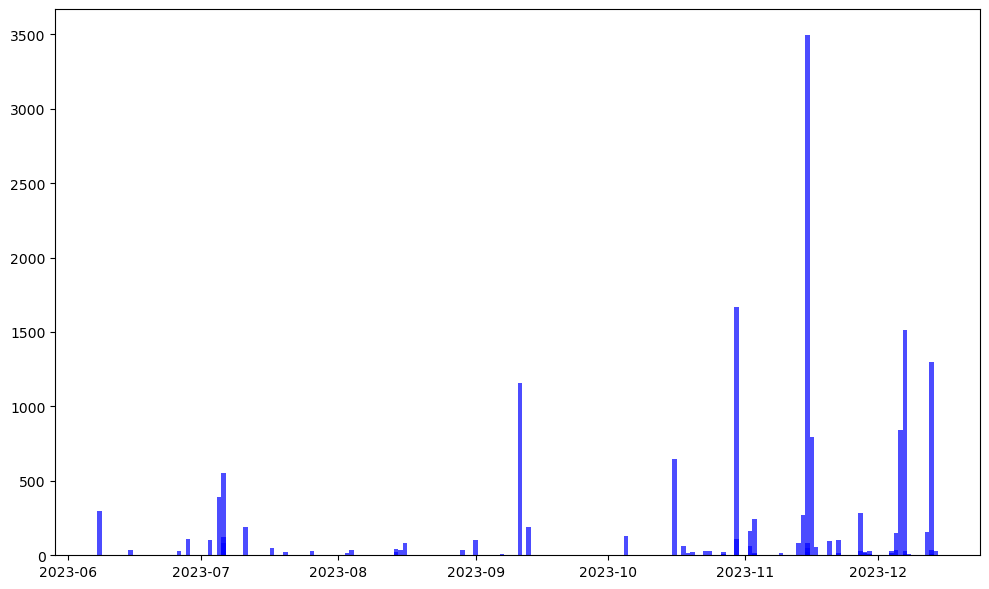

In [35]:

merged_df['date_utc'] = pd.to_datetime(merged_df['date_utc'])
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(merged_df['date_utc'], merged_df['upvotes'], color='b', alpha=0.7, label='Upvotes', width=1)
ax1.bar(merged_df['date_utc'], merged_df['num_comments'], color='r', alpha=0.7, label='Comments', width=1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Upvotes and Comments', color='m')
ax1.tick_params('y', colors='m')
ax2 = ax1.twinx()
ax2.plot(merged_df['date_utc'], merged_df['Open'], color='k', label='Price')
ax2.set_ylabel('Price', color='k')
ax2.tick_params('y', colors='k')

leg = ax1.legend(loc ="upper left")

plt.title('Upvotes and Number of Comments Over Time')
plt.show()

<Axes: >

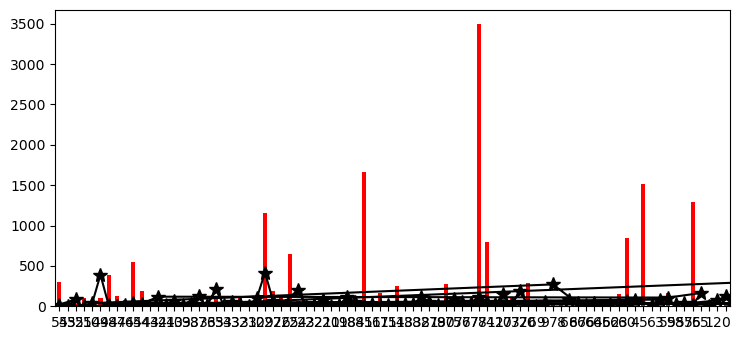

In [15]:
#merged_df[['upvotes', 'num_comments']].plot(kind='bar',figsize=(7.50, 3.50))
#merged_df[['scaled_price']].plot(kind='line',figsize=(7.50, 3.50))
#plt.title('Trends over Time')
#plt.show()



plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

df = merged_df[['upvotes', 'num_comments', 'scaled_price']]
fig, ax = plt.subplots()

df['upvotes'].plot(kind='bar', color='red')
df['num_comments'].plot(kind='line', marker='*', color='black', ms=10)


In [16]:
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr
data1 = merged_df['upvotes']
data2 = merged_df['num_comments']
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably independent')
else:
 print('Probably dependent')

stat=0.714, p=0.000
Probably dependent
